# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road**
<div style="text-align: right"><font size="1">Alejandra Vargas - 10.10.17</font></div>

***
<div style="text-align: justify"> In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream. </div>



## Import Packages

In [21]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
import os
from sklearn.linear_model import LinearRegression
%matplotlib inline

## Define Functions

In [31]:
def grayscale(img):
    """Applies the Grayscale transform"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
def canny(img, low_threshold, high_threshold):
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    threshold_angle = 25 
    threshold_slope = math.tan(threshold_angle / 180 * math.pi)
    left_line_x = []
    left_line_y = []
    right_line_x = []
    right_line_y = []

    for line in lines:
        for x1, y1, x2, y2 in line:
            if x2 != x1:
                slope = float(y2 - y1) / float(x2 - x1) #get slope ((y2-y1)/(x2-x1))
                if abs(slope) < threshold_slope:   # discard lines with and angle between -25 and 25 degrees
                    continue
                elif slope < 0:  # the left line has a negative slope
                    left_line_x.append([x1])
                    left_line_y.append([y1])
                    left_line_x.append([x2])
                    left_line_y.append([y2])
                else:
                    right_line_x.append([x1])
                    right_line_y.append([y1])
                    right_line_x.append([x2])
                    right_line_y.append([y2])

    # use regression to find lines
    if len(left_line_x) > 0:
        line_regression(img, left_line_x, left_line_y)
    if len(right_line_x) > 0:
        line_regression(img, right_line_x, right_line_y)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

# buffer to store the slope and y-intercept values for each line detected in the last N frames
slope_l = []
slope_r = []
yinter_l = []  
yinter_r = []

def clear_buffer():
    """
    Reset buffer content
    """
    slope_l.clear()
    yinter_l.clear()
    slope_r.clear()
    yinter_r.clear()

def white_yellow(img):
    """
    White and yellow selction
    NOTE: For HSV, Hue range is [0,179], Saturation range is [0,255] and Value range is [0,255]
    """
    sensitivity = 10
    
    # define range of yellow color in HSV
    lower_yellow = np.array([70, 100, 100], np.uint8)
    upper_yellow = np.array([100, 255, 255], np.uint8)
    # Threshold the HSV image to get only yellow colors
    yellow_mask = cv2.inRange(img, lower_yellow, upper_yellow)

    # define range of white color in HSV
    lower_white = np.array([0,0,200], dtype=np.uint8)
    upper_white = np.array([180,25,255], dtype=np.uint8)
    # Threshold the HSV image to get only white colors
    white_mask = cv2.inRange(img, lower_white, upper_white)
    
    # Bitwise-AND mask and original image
    img = cv2.bitwise_and(img, img, mask=cv2.bitwise_or(yellow_mask, white_mask))
    return img

def clear_outlier(prediction, x, y, inlier_percent=0.9):
    threshold = 10  
    err = np.fabs(y - prediction) #this function returns the absolute values of the data in x
    max_err = max(err)[0] #get largest residual errors
    if max_err > threshold:  # if the biggest error is greater than 10 pixels, the outliers are removed
        ceiling = math.ceil(err.size * inlier_percent) #return the ceiling of x, the smallest integer greater than or equal to x.
        c_index = np.argsort(err, axis=0)[:ceiling]
        if c_index.size > 0:
            x = np.take(x, c_index)
            y = np.take(y, c_index)

    return (x, y)

def end_points(slope, yinter, side, height):
    """
    Locate the two end points of a line
    """
    buffer_frames = 3
    scale_y = 0.65
    top_y = int(float(height) * scale_y)  

    if side == 'l':
        if len(slope_l) == buffer_frames: 
            slope_l.pop(0) 
            yinter_l.pop(0)

        slope_l.append(slope)
        yinter_l.append(yinter)
        slope = sum(slope_l) / len(slope_l)
        yinter= sum(yinter_l) / len(yinter_l)

        point_1_y = height-1
        point_1_x = int((float(point_1_y)-yinter)/slope)
        point_2_y = top_y
        point_2_x = int((float(point_2_y)-yinter)/slope)
    else: 
        if len(slope_r) == buffer_frames: 
            slope_r.pop(0) 
            yinter_r.pop(0)

        slope_r.append(slope)
        yinter_r.append(yinter)
        slope = sum(slope_r) / len(slope_r)
        yinter= sum(yinter_r) / len(yinter_r)

        point_1_y = top_y
        point_1_x = int((float(point_1_y)-yinter)/slope)
        point_2_y = height-1
        point_2_x = int((float(point_2_y)-yinter)/slope)

    return (point_1_x, point_1_y, point_2_x, point_2_y)


def line_regression(img, x, y, color=[255, 0, 0], thickness=10):
    reg = LinearRegression()
    reg.fit(x, y)
    clean_data = []
    try:
        prediction = reg.predict(x)
        clean_data = clear_outlier(prediction, x, y)
    except NameError:
        print("Regression Prediction Error")

    if len(clean_data) > 0:
        x, y = clean_data   
        try:
            reg.fit(x, y)
        except NameError:
            print("Error in reg.fit for clean_data")
    else:
        print("clear_outlier() list is blank")

    height = img.shape[0]
    slope = reg.coef_
    yinter= reg.intercept_

    if reg.coef_ < 0: 
        point_1_x, point_1_y, point_2_x, point_2_y = end_points(slope, yinter, 'l', height)
        cv2.line(img, (point_1_x, point_1_y), (point_2_x, point_2_y), color, thickness)
    else: 
        point_1_x, point_1_y, point_2_x, point_2_y = end_points(slope, yinter, 'r', height)
        cv2.line(img, (point_1_x, point_1_y), (point_2_x, point_2_y), color, thickness)

## Line Finding Pipeline

In [37]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.

def draw_pipeline(image):
    kernel_size = 5
    low_threshold = 50
    high_threshold = 150
    height, width, _ = image.shape
    width_scale = 2 / 5
    height_scale = 2 / 3
    left_bottom = [0, height - 1]
    right_bottom = [width - 1, height - 1]
    left_up = [width_scale * width, height_scale * height]
    right_up = [(1 - width_scale) * width, height_scale * height]
    rho = 2 
    theta = np.pi / 180  
    threshold = 15  
    min_line_length = 15  
    max_line_gap = 40

    blur_gray = gaussian_blur(image, kernel_size)
    hsv_img = cv2.cvtColor(blur_gray, cv2.COLOR_BGR2HSV)
    filtered_hsv = white_yellow(hsv_img)
    edges = canny(filtered_hsv, low_threshold, high_threshold)
    vertexes = np.array([[left_bottom, left_up, right_up, right_bottom]], dtype=np.int32)
    masked_edges = region_of_interest(edges, vertexes)
    line_image = hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)
    output = weighted_img(line_image, image)

    return output

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

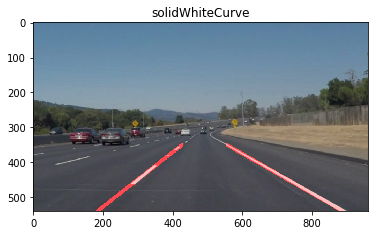

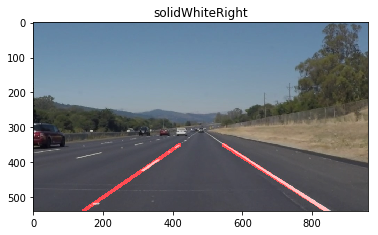

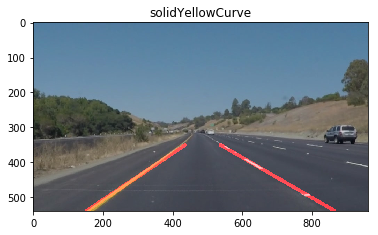

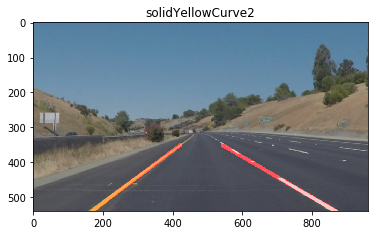

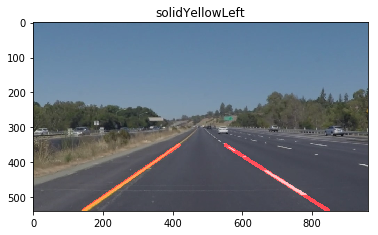

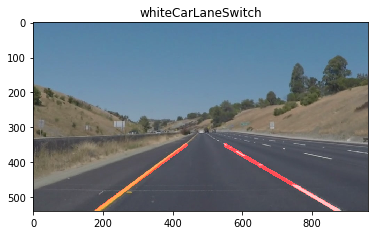

In [38]:
for test_img in os.listdir("test_images/"):
    fileName, ending = os.path.splitext(test_img)
    if ending != ".jpg":
        continue

    image = mpimg.imread(os.path.join("test_images", fileName + ending))
    
    clear_buffer()
    image_output = draw_pipeline(image)

    # copy output image in new folder
    new_filename = os.path.join("test_images_output",fileName + "_output.jpg")
    mpimg.imsave(new_filename, image_output)

    plt.imshow(image_output)
    plt.title(fileName)
    plt.show(block=True)

## Test on Videos

In [28]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [29]:
def process_image(image):
    '''
    Return final output
    '''   
    result = draw_pipeline(image) 
    return result

### Pipeline in "solidWhiteRight" video

In [34]:
clear_buffer()
white_output = 'test_videos_output/solidWhiteRight.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:16<00:00, 13.47it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 11.4 s, sys: 2.13 s, total: 13.5 s
Wall time: 17.8 s


### "solidWhiteRight" video inline

In [11]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

### Pipeline in "solidYellowLeft" output video

In [12]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:47<00:00, 14.37it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 34.1 s, sys: 5.94 s, total: 40 s
Wall time: 48.6 s


### "solidYellowLeft" output video inline

In [13]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

### Pipeline in "challenge" video

In [55]:
challenge_output = 'test_videos_output/challenge.mp4'
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|██████████| 251/251 [00:30<00:00,  7.01it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 22 s, sys: 4.43 s, total: 26.5 s
Wall time: 33.5 s


### "challenge" output video inline

In [56]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))